---
title: "Logistic regression"
format:
  html:
    code-fold: true
jupyter: python3
author: "kakamana"
date: "2023-01-18"
categories: [python, datacamp, linear classifier, logistic regression, machine learning, SVM ]
image: "logisticRegression.jpg"

---

# Logistic regression

We will discover the conceptual framework behind logistic regression and SVMs. This will let us delve deeper into the inner workings of these models.

This **Logistic regression** is part of [Datacamp course: Linear Classifiers in Python](https://app.datacamp.com/learn/courses/linear-classifiers-in-python)

This is my learning experience of data science through DataCamp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 5)

## Logistic regression and regularization
- Regularized logistic regression
    - Hyperparameter "C" is the inverse of the regularization strength
        - Larger "C": less regularization
        - Smaller "C": more regularization
    - regularized loss = original loss + large coefficient penalty
        - more regularization: lower training accuracy
        - more regularization: (almost always) higher test accuracy
- L1 vs. L2 regularization
    - Lasso = linear regression with L1 regularization
    - Ridge = linear regression with L2 regularization


### Regularized logistic regression
Earlier we used logistic regression on the handwritten digits data set. Here, we'll explore the effect of L2 regularization. The handwritten digits dataset is already loaded, split, and stored in the variables X_train, y_train, X_valid, and y_valid. The variables train_errs and valid_errs are already initialized as empty lists.



In [2]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

digits = load_digits()

X_train, X_valid, y_train, y_valid = train_test_split(digits.data, digits.target)


As you can see, too much regularization (small C) doesn’t work well – due to underfitting – and too little regularization (large C) doesn’t work well either – due to overfitting.


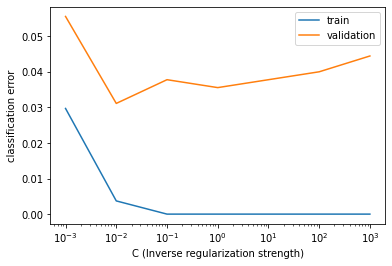

In [6]:
# Train and validation errors initialized as empty list
train_errs = list()
valid_errs = list()

# Loop over values of C_value
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for C_value in C_values:
    # Create LogisticRegression object and fit
    lr = LogisticRegression(C=C_value, max_iter=10000)
    lr.fit(X_train, y_train)

    # Evalueate error rates and append to lists
    train_errs.append(1.0 - lr.score(X_train, y_train))
    valid_errs.append(1.0 - lr.score(X_valid, y_valid))

# Plot results
plt.semilogx(C_values, train_errs, C_values, valid_errs);
plt.ylabel('classification error')
plt.xlabel('C (Inverse regularization strength)')
plt.legend(("train", "validation"));
print("\nAs you can see, too much regularization (small C) doesn’t work well – due to underfitting – and too little regularization (large C) doesn’t work well either – due to overfitting.")

### Logistic regression and feature selection
In this exercise we'll perform feature selection on the movie review sentiment data set using L1 regularization. The features and targets are already loaded for you in `X_train` and `y_train`.

We'll search for the best value of C using scikit-learn's `GridSearchCV()`, which was covered in the prerequisite course.

In [8]:
from sklearn.datasets import load_svmlight_file

X_train, y_train = load_svmlight_file('dataset/aclImdb_v1/aclImdb/train/labeledBow.feat')
y_train[y_train < 5] = -1.0
y_train[y_train >= 5] = 1.0

In [9]:
from sklearn.model_selection import GridSearchCV

# Specify L1 regularization
lr = LogisticRegression(penalty='l1', solver='liblinear')

# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[0.001, 0.01, 0.1, 1, 10]})
searcher.fit(X_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (select features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Best CV params {'C': 0.1}
Total number of features: 89527
Number of selected features: 1106


### Identifying the most positive and negative words
In this exercise we'll try to interpret the coefficients of a logistic regression fit on the movie review sentiment dataset. The model object is already instantiated and fit for you in the variable `lr`.

In addition, the words corresponding to the different features are loaded into the variable `vocab`. For example, since `vocab[100]` is "think", that means feature 100 corresponds to the number of times the word "think" appeared in that movie review.

In [12]:
vocab = pd.read_csv('dataset/vocab.csv').to_numpy()

In [21]:
lr
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

In [18]:
vocab.shape

(2500, 1)

In [20]:
vocab[:3]

array([['the'],
       ['and'],
       ['a']], dtype=object)

In [19]:
vocab[-3:]

array([['birth'],
       ['sorts'],
       ['gritty']], dtype=object)

In [22]:
inds_ascending = np.argsort(best_lr.coef_.flatten())
inds_descending = inds_ascending[::-1]

In [23]:
# Print the most positive words
print("Most positive words: ", end="")
for i in range(5):
    print(vocab[inds_descending[i]], end=", ")
print("\n")

# Print most negative words
print("Most negative words: ", end="")
for i in range(5):
    print(vocab[inds_ascending[i]], end=", ")
print("\n")

Most positive words: ['excellent'], ['refreshing'], ['wonderfully'], ['perfect'], ['superb'], 

Most negative words: ['waste'], ['worst'], ['disappointment'], ['poorly'], ['awful'], 



## Logistic regression and probabilities
- Regularization is supposed to combat overfitting, and there is a connection between overconfidence and overfitting
- How are these probabilities computed?
    - logistic regression predictions: sign of raw model output
    - logistic regression probabilities: "squashed" raw model output

### Regularization and probabilities
In this exercise, you will observe the effects of changing the regularization strength on the predicted probabilities.

In [24]:
X = pd.read_csv('./dataset/binary_X.csv').to_numpy()
y = pd.read_csv('./dataset/binary_y.csv').to_numpy().ravel()

In [26]:
def make_meshgrid(x, y, h=.02, lims=None):
    """Create a mesh of points to plot in

    Parameters
    ----------
        x: data to base x-axis meshgrid on
        y: data to base y-axis meshgrid on
        h: stepsize for meshgrid, optional

    Returns
    -------
        xx, yy : ndarray
    """

    if lims is None:
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
    else:
        x_min, x_max, y_min, y_max = lims
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, proba=False, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
        ax: matplotlib axes object
        clf: a classifier
        xx: meshgrid ndarray
        yy: meshgrid ndarray
        params: dictionary of params to pass to contourf, optional
    """
    if proba:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,-1]
        Z = Z.reshape(xx.shape)
        out = ax.imshow(Z,extent=(np.min(xx), np.max(xx), np.min(yy), np.max(yy)),
                        origin='lower', vmin=0, vmax=1, **params)
        ax.contour(xx, yy, Z, levels=[0.5])
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_classifier(X, y, clf, ax=None, ticks=False, proba=False, lims=None):
    # assumes classifier "clf" is already fit
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1, lims=lims)

    if ax is None:
        plt.figure()
        ax = plt.gca()
        show = True
    else:
        show = False

    # can abstract some of this into a higher-level function for learners to call
    cs = plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8, proba=proba)
    if proba:
        cbar = plt.colorbar(cs)
        cbar.ax.set_ylabel('probability of red $\Delta$ class', fontsize=20, rotation=270, labelpad=30)
        cbar.ax.tick_params(labelsize=14)
        #ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=30, edgecolors=\'k\', linewidth=1)
    labels = np.unique(y)
    if len(labels) == 2:
        ax.scatter(X0[y==labels[0]], X1[y==labels[0]], cmap=plt.cm.coolwarm,
                   s=60, c='b', marker='o', edgecolors='k')
        ax.scatter(X0[y==labels[1]], X1[y==labels[1]], cmap=plt.cm.coolwarm,
                   s=60, c='r', marker='^', edgecolors='k')
    else:
        ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=50, edgecolors='k', linewidth=1)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    #     ax.set_xlabel(data.feature_names[0])
    #     ax.set_ylabel(data.feature_names[1])
    if ticks:
        ax.set_xticks(())
        ax.set_yticks(())
        #     ax.set_title(title)
    if show:
        plt.show()
    else:
        return ax

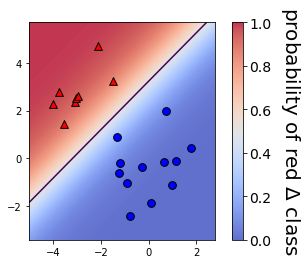

Maximum predicted probability 0.9973143426900802


In [27]:
# Set the regularization strength
model = LogisticRegression(C=1)

# Fit and plot
model.fit(X, y)
plot_classifier(X, y, model, proba=True)

# Predict probabilities on training points
prob = model.predict_proba(X)
print("Maximum predicted probability", np.max(prob))

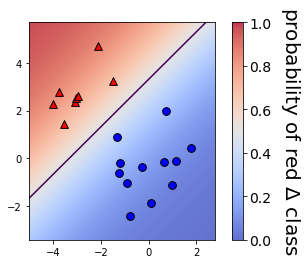

Maximum predicted probabilty 0.9352061680350907

As you probably noticed, smaller values of C lead to less confident predictions. That's because smaller C means more regularization, which in turn means smaller coefficients, which means raw model outputs closer to zero and, thus, probabilities closer to 0.5 after the raw model output is squashed through the sigmoid function. That's quite a chain of events!


In [29]:
# Set the regularization strength
model = LogisticRegression(C=0.1)

# Fit and plot
model.fit(X, y)
plot_classifier(X, y, model, proba=True)

# Predict probabilities on training points
prob = model.predict_proba(X)
print("Maximum predicted probabilty", np.max(prob))
print("\nAs you probably noticed, smaller values of C lead to less confident predictions. That's because smaller C means more regularization, which in turn means smaller coefficients, which means raw model outputs closer to zero and, thus, probabilities closer to 0.5 after the raw model output is squashed through the sigmoid function. That's quite a chain of events!")

### Visualizing easy and difficult examples
We'll visualize the examples that the logistic regression model is most and least confident about by looking at the largest and smallest predicted probabilities.

In [31]:
def show_digit(i, lr=None):
    plt.imshow(np.reshape(X[i], (8,8)), cmap='gray',
               vmin = 0, vmax = 16, interpolation=None)
    plt.xticks(())
    plt.yticks(())
    if lr is None:
        plt.title("class label = %d" % y[i])
    else:
        pred = lr.predict(X[i][None])
        pred_prob = lr.predict_proba(X[i][None])[0,pred]
        plt.title("label=%d, prediction=%d, proba=%.2f" % (y[i], pred, pred_prob))
        plt.show()

In [32]:
X, y = digits.data, digits.target

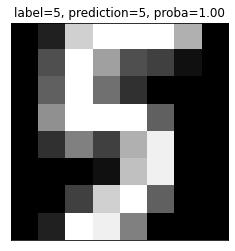

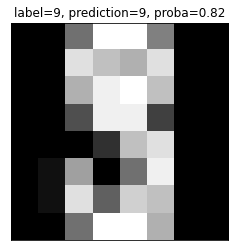


As you can see, the least confident example looks like a weird 9, and the most confident example looks like a very typical 5


In [34]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X, y)

# Get predicted probabilties
proba = lr.predict_proba(X)

# Sort the example indices by their maximum probabilty
proba_inds = np.argsort(np.max(proba, axis=1))

# Show the most confident (least ambiguous) digit
show_digit(proba_inds[-1], lr)

# Show the least confident (most ambiguous) digit
show_digit(proba_inds[0], lr)
print("\nAs you can see, the least confident example looks like a weird 9, and the most confident example looks like a very typical 5")

 If you fit a logistic regression model on a classification problem with 3 classes and 100 features, how many coefficients would you have, including intercepts?

303

100 coefficients + 1 intercept for each binary classifier. (A, B), (B, C), (C, A)
101 * 3 = 303

## Multi-class logistic regression
- One-vs-rest:
    - fit a binary classifier for each class
    - predict with all, take largest output
    - pro: simple, modular
    - con: not directly optimizing accuracy
    - common for SVMs as well
- "Multinomial" or "Softmax":
    - fit a single classifier for all classes
    - prediction directly outputs best class
    - pro: tackle the problem directly
    - con: more complicated, new code
    - possible for SVMs, but less common

### Fitting multi-class logistic regression
We'll fit the two types of multi-class logistic regression, one-vs-rest and softmax/multinomial, on the handwritten digits data set and compare the results.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target)

In [37]:
# Fit one-vs-rest logistic regression classifier
lr_ovr = LogisticRegression(multi_class='ovr',max_iter=10000)
lr_ovr.fit(X_train, y_train)

print("OVR training accuracy:", lr_ovr.score(X_train, y_train))
print("OVR test accuracy:", lr_ovr.score(X_test, y_test))

# Fit softmax classifier
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
lr_mn.fit(X_train, y_train)
print("Softmax training accuracy:", lr_mn.score(X_train, y_train))
print("Softmax test accuracy:", lr_mn.score(X_test, y_test))
print("\nthe accuracies of the two methods are fairly similar on this data set.")

OVR training accuracy: 0.9985152190051967
OVR test accuracy: 0.9511111111111111
Softmax training accuracy: 1.0
Softmax test accuracy: 0.9622222222222222

the accuracies of the two methods are fairly similar on this data set.


### Visualizing multi-class logistic regression
We'll continue with the two types of multi-class logistic regression, but on a toy 2D data set specifically designed to break the one-vs-rest scheme.


In [38]:
X_train = pd.read_csv('./dataset/toy_X_train.csv').to_numpy()
y_train = pd.read_csv('./dataset/toy_y_train.csv').to_numpy().ravel()

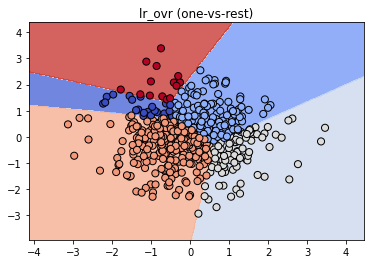

In [39]:
lr_ovr = LogisticRegression(max_iter=10000, C=100)
lr_ovr.fit(X_train, y_train)

fig, ax = plt.subplots();
ax.set_title("lr_ovr (one-vs-rest)");
plot_classifier(X_train, y_train, lr_ovr, ax=ax);

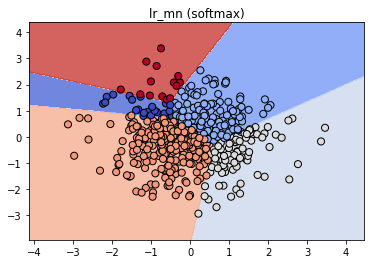

In [40]:
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
lr_mn.fit(X_train, y_train)

fig, ax = plt.subplots();
ax.set_title("lr_mn (softmax)");
plot_classifier(X_train, y_train, lr_ovr, ax=ax);

Softmax training accuracy: 0.952
One-vs-rest training accuracy: 0.996


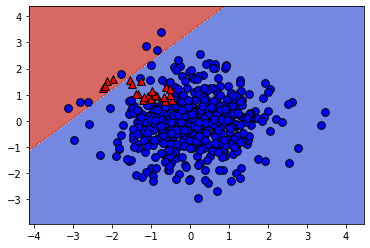


the binary classifier incorrectly labels almost all points in class 1 (shown as red triangles in the final plot)! Thus, this classifier is not a very effective component of the one-vs-rest classifier. In general, though, one-vs-rest often works well.


In [42]:
print("Softmax training accuracy:", lr_mn.score(X_train, y_train))
print("One-vs-rest training accuracy:", lr_ovr.score(X_train, y_train))

# Create the binary classifier (class 1 vs. rest)
lr_class_1 = LogisticRegression(max_iter=10000, C=100)
lr_class_1.fit(X_train, y_train == 1)

# Plot the binary classifier (class 1 vs. rest)
plot_classifier(X_train, y_train == 1, lr_class_1);
print("\nthe binary classifier incorrectly labels almost all points in class 1 (shown as red triangles in the final plot)! Thus, this classifier is not a very effective component of the one-vs-rest classifier. In general, though, one-vs-rest often works well.")

### One-vs-rest SVM
As motivation for the next and final chapter on support vector machines, we'll repeat the previous exercise with a non-linear SVM. Once again, the data is loaded into X_train, y_train, X_test, and y_test .

Instead of using `LinearSVC`, we'll now use scikit-learn's `SVC` object, which is a non-linear "kernel" SVM. Again, your task is to create a plot of the binary classifier for class 1 vs. rest.

In [43]:
X_test = pd.read_csv('./dataset/toy_X_test.csv').to_numpy()
y_test = pd.read_csv('./dataset/toy_y_test.csv').to_numpy().ravel()

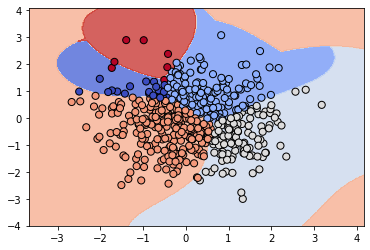

In [44]:
from sklearn.svm import SVC

# Create/plot the binary classifier
svm_class_1 = SVC()
svm_class_1.fit(X_train, y_train)
plot_classifier(X_test, y_test, svm_class_1)

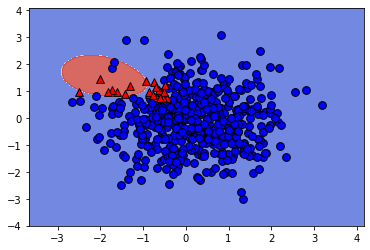


The non-linear SVM works fine with one-vs-rest on this dataset because it learns to "surround" class 1


In [46]:
# Create/plot the binary classifier
svm_class_1 = SVC()
svm_class_1.fit(X_train, y_train == 1)
plot_classifier(X_test, y_test == 1, svm_class_1)
print('\nThe non-linear SVM works fine with one-vs-rest on this dataset because it learns to "surround" class 1')